In [1]:
import os
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10  # Changed from mnist
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
import bloqade
from bloqade.ir.location import Chain, start


In [16]:
import time

In [2]:
import bloqade
from bloqade.ir.location import Chain, start

X_train: (50000, 32, 32, 3)
Y_train: (50000, 1)
X_test: (10000, 32, 32, 3)
Y_test: (10000, 1)


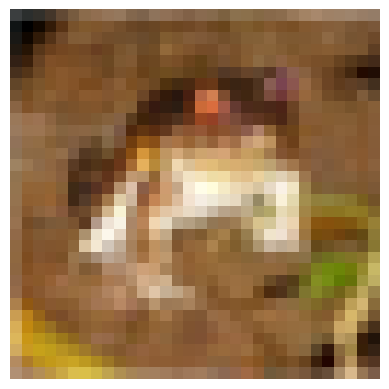

In [4]:
# Load CIFAR-10 dataset and rescaling data
(train_X, train_y), (test_X, test_y) = cifar10.load_data()
train_X, test_X = train_X / 255.0, test_X / 255.0

# Data Dimensions
print('X_train:', train_X.shape)
print('Y_train:', train_y.shape)
print('X_test:', test_X.shape)
print('Y_test:', test_y.shape)

# example of an training dataset 
plt.imshow(train_X[0], cmap=plt.get_cmap('gray'), interpolation='None')
plt.axis('off')
plt.show()

In [6]:
# We first use PCA to downsample the data into 10-dimensional vectors
dim_pca = 8
num_examples = 1000
num_test_examples = 200

# Use the `fit` function from the `sklearn` package to define the PCA model and apply to training set
train_X_reshaped = np.reshape(train_X, (len(train_X), -1))
test_X_reshaped = np.reshape(test_X, (len(test_X), -1))

pca=PCA(n_components=dim_pca).fit(train_X_reshaped)
xs = pca.transform(train_X_reshaped)[:num_examples,:]
xt=pca.transform(test_X_reshaped)[:num_test_examples,:]

# Let us see how it looks
print("Training set PCA: \n ", xs[0:5,:], "\n")

#processing the test set
# Let us see how it looks
print("Test set PCA: \n ", xt[0:5,:], "")

Training set PCA: 
  [[-6.40101763e+00  2.72903876e+00  1.50171052e+00  2.95333215e+00
   4.45258258e+00  6.47149958e-01  5.68986220e-01  9.28834333e-02]
 [ 8.29783385e-01 -9.49943219e-01  6.00375260e+00 -1.50493074e+00
   1.36850240e+00  1.22568440e+00  6.06899832e-01 -5.22881814e-01]
 [ 7.73019978e+00 -1.15221023e+01 -2.75362051e+00 -2.33359487e+00
   1.58440759e+00 -2.27220860e+00 -6.10444124e-01 -1.36143919e+00]
 [-1.03478173e+01  1.07381130e-02  1.10101881e+00  1.30454034e+00
   1.59486951e+00  8.67599483e-01  1.94111689e-01  2.32407309e-01]
 [-2.62565098e+00 -4.96923990e+00  1.03458548e+00 -3.30645747e+00
  -1.26168555e+00  3.12354808e-02  5.65550129e+00  1.42667535e+00]] 

Test set PCA: 
  [[-3.47967057  0.90642637  1.25195572 -3.16419262  1.91824559  1.65949855
  -0.06809121  0.16057353]
 [ 9.94315784 -9.58055259  5.068578    2.96119979 -1.11001203 -0.26661162
  -1.1476403  -3.26161724]
 [ 4.70429957 -8.83720616  4.10928531 -1.03072134 -0.2044476  -0.91175006
   5.31384971  1.1

In [10]:
 spectral = np.amax(xs) - np.amin(xs)
 m1 = np.amin(xs)
 xs = (xs - m1) / spectral  # to make sure values to be between [0, 1]
 xt=pca.transform(np.reshape(test_X, (10000,-1)))
 num_test_examples = 200
 xs_test = xt[:num_test_examples,:]
 xs_test = (xs_test - m1)/spectral

In [11]:
QRC_parameters = {
    "atom_number": dim_pca,
    "geometry_spec": Chain(dim_pca, lattice_spacing=10),
    "encoding_scale": 9.0,
    "rabi_frequency": 6.283,
    "total_time": 4,
    "time_steps": 8,
    "readouts": "ZZ",
}

In [12]:
 #Main function for building quantum tasks.
 def build_task(QRC_parameters, xs1):
     natoms=QRC_parameters["atom_number"]
     encoding_scale=QRC_parameters["encoding_scale"]
     dt=QRC_parameters["total_time"]/QRC_parameters["time_steps"]
     #builds global Rabi and detuning pulses
     rabi_oscillations_program = (QRC_parameters["geometry_spec"]
             .rydberg.rabi.amplitude.uniform.constant(
                 duration="run_time", value=QRC_parameters["rabi_frequency"]
             )
             .detuning.uniform.constant(duration="run_time", value=encoding_scale/2)
             #adds local detuning according to the feature vector
             .scale(list(xs1)).constant(duration="run_time", value=-encoding_scale)
             )
     rabi_oscillation_job = rabi_oscillations_program.batch_assign(run_time=np.arange(1, QRC_parameters["time_steps"]+1, 1)*dt)
     #`batch_assign` used to probe the quantum reservoir at set number of timesteps
     return rabi_oscillation_job

 #To obtain the embeddings, we process the report containing the collected samples into embeddins made of Z and ZZ observables.
 def process_results(QRC_parameters, report):
     embedding=[]
     natoms=QRC_parameters["atom_number"]
     try:
         for t in range(QRC_parameters["time_steps"]):
             ar1=-1.0+2*((report.bitstrings())[t])
             nsh1=ar1.shape[0]
             for i in range(natoms):
                 embedding.append(np.sum(ar1[:,i])/nsh1) #Z expectation values
             if QRC_parameters["readouts"]=="ZZ":
                 for i in range(natoms):
                     for j in range(i+1,natoms):
                         embedding.append(np.sum(ar1[:,i]*ar1[:,j])/nsh1) #ZZ expectation values
     except: #In case no experimental results were obtained.
         print("No results exist.")
         for t in range(QRC_parameters["time_steps"]):
             for i in range(natoms):
                 embedding.append(0.0)
             if QRC_parameters["readouts"]=="ZZ":
                 for i in range(natoms):
                     for j in range(i+1,natoms):
                         embedding.append(0.0)
     return embedding

 #Processing if only samples are needed.
 def process_results_samples(QRC_parameters, report):
     embedding=[]
     natoms=QRC_parameters["atom_number"]
     try:
         embedding=report.bitstrings()
         # for t in range(QRC_parameters["time_steps"]):\n",
         #     ar1=-1.0+2*((report.bitstrings())[t])\n",
         #     nsh1=ar1.shape[0]\n",
         #     for i in range(natoms):\n",
         #         embedding.append(np.sum(ar1[:,i])/nsh1) #Z expectation values\n",
         #     if QRC_parameters["readouts"]=="ZZ":\n",
         #         for i in range(natoms):\n",
         #             for j in range(i+1,natoms):\n",
         #                 embedding.append(np.sum(ar1[:,i]*ar1[:,j])/nsh1) #ZZ expectation values\n",
     except: #In case no experimental results were obtained.
         print("No results exist.")
         for t in range(QRC_parameters["time_steps"]):
             for i in range(natoms):
                 embedding.append(0.0)
             if QRC_parameters["readouts"]=="ZZ":
                 for i in range(natoms):
                     for j in range(i+1,natoms):
                         embedding.append(0.0)
     return embedding

In [19]:

def get_embeddings_emulation(xs, num_examples, nshots=1000):
    start_time = time.time()
    result = np.array([process_results(QRC_parameters,
        build_task(QRC_parameters, xs[data,:]).bloqade.python().run(shots=nshots, rtol=1e-8, atol=1e-8).report())
        for data in range(num_examples)])
    end_time = time.time()
    print(f"Bloqade Simulation Time: {round(end_time-start_time, 2)} seconds")
    return result

In [20]:
embeddings=get_embeddings_emulation(xs, num_examples, nshots=1000)
test_embeddings=get_embeddings_emulation(xs_test, num_test_examples, nshots=1000)

print(embeddings.shape)
print(test_embeddings.shape)

Bloqade Simulation Time: 1272.7 seconds
Bloqade Simulation Time: 372.6 seconds
(1000, 288)
(200, 288)


In [18]:
#building a linear model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10)
    ])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#fitting to train data
model.fit(xs, train_y[:num_examples], epochs=1000, batch_size=100, verbose=0)

#evaluating on test data
test_loss, test_acc = model.evaluate(xs_test,  test_y[:num_test_examples], verbose=0)
print('PCA test accuracy:', 100*round(test_acc, 2), "%")

PCA test accuracy: 31.0 %


In [21]:
#building a linear model
#we include regularization and tune epsilon parameter of the optimizer to better control training from QRC embeddings generated on finite number of samples
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, kernel_regularizer=tf.keras.regularizers.L1(l1=0.0001))
    ])
model.compile(optimizer=tf.keras.optimizers.Adam(epsilon=0.0002),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#fitting to train data
model.fit(embeddings, train_y[:num_examples], epochs=2000, batch_size=100, verbose=0)

#evaluating on test data
test_loss, test_acc = model.evaluate(test_embeddings,  test_y[:num_test_examples], verbose=0)
print('QRC test accuracy:', 100*round(test_acc, 2), "%")

QRC test accuracy: 12.0 %
